In [1]:
pip install opencv-python-headless imageio numpy

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 37.3 MB 187 kB/s eta 0:00:01     |████████████▊                   | 14.9 MB 581 kB/s eta 0:00:39     |█████████████████████████████   | 33.9 MB 265 kB/s eta 0:00:14
You should consider upgrading via the '/Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import numpy as np
import cv2
import imageio.v2 as imageio
import matplotlib.pyplot as plt
from skimage.transform import warp
from skimage.transform import SimilarityTransform

In [22]:
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Define input and output directories
base_dir = "data"
# base_dir = "/content/drive/MyDrive/Image Stacking/data"
input_dir = os.path.join(base_dir, "Processed_Images")
output_dir = os.path.join(base_dir, "Aligned_Images")

# Create output folder if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Load all TIFF images
image_files = sorted([f for f in os.listdir(input_dir) if f.endswith(".tiff")])

In [24]:
# Define input and output directories
test_base_dir = "test_data"
input_dir = os.path.join(test_base_dir, "Raw_Images")
output_dir = os.path.join(test_base_dir, "Aligned_Images")

# Create output folder if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Load all JPEG images
image_files = sorted([f for f in os.listdir(input_dir) if f.endswith(".jpg") or f.endswith(".jpeg") or f.endswith(".tif")])


In [25]:
# Read the first image as reference
ref_img = imageio.imread(os.path.join(input_dir, image_files[0]))

# Convert reference to grayscale
ref_gray = cv2.cvtColor(ref_img, cv2.COLOR_RGB2GRAY)

# Convert grayscale image to 8-bit (required for ORB)
ref_gray_8bit = cv2.normalize(ref_gray, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

In [26]:
# Feature Detector: ORB (Oriented FAST and Rotated BRIEF)
# ORB (Oriented FAST and Rotated BRIEF) is a feature detection algorithm that finds unique points in an image.
# We create an ORB detector that detects up to 500 keypoints per image.
orb = cv2.ORB_create(nfeatures=500)

# Detect keypoints & descriptors in the reference image
# Detects keypoints (interesting points in the image like corners, edges, or textures - in our case, maybe a star).
# Computes descriptors (numerical representations of keypoints that allow matching between images).
# keypoints_ref: A list of detected keypoints (each with position, orientation, and scale).
# descriptors_ref: A matrix of feature vectors representing each keypoint.
keypoints_ref, descriptors_ref = orb.detectAndCompute(ref_gray_8bit, None)

# FLANN Matcher
# FLANN (Fast Library for Approximate Nearest Neighbors) is an optimized algorithm for fast feature matching.
# It matches the ORB descriptors from one image to another.
index_params = dict(algorithm=6, table_number=12, key_size=20, multi_probe_level=2)
search_params = dict() # Left empty, defaults will be used. Can be modified to control how many nearest neighbors are searched.
flann = cv2.FlannBasedMatcher(index_params, search_params)

# algorithm=6 → Uses LSH (Locality-Sensitive Hashing), which is efficient for ORB descriptors.
# table_number=12 → Number of hash tables. More tables = better accuracy.
# key_size=20 → Length of feature vectors used for hashing.
# multi_probe_level=2 → Allows searching nearby buckets to improve accuracy.

In [27]:
aligned_images = []

for i, filename in enumerate(image_files):
    img_path = os.path.join(input_dir, filename)
    img = imageio.imread(img_path)  # Load as RGB

    # Convert to grayscale
    img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Convert 16-bit grayscale image to 8-bit for ORB
    img_gray_8bit = cv2.normalize(img_gray, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    # Detect keypoints
    keypoints, descriptors = orb.detectAndCompute(img_gray_8bit, None)

    # Match features using FLANN
    # This finds the two best matches (k=2) for each feature.
    # matches is a list of lists, where each inner list contains two matches.
    matches = flann.knnMatch(descriptors, descriptors_ref, k=2)

    # Apply Lowe's ratio test to filter good matches
    # If the best match is much better (closer) than the second-best match, it is considered a good match.
    # The threshold (0.7) ensures that only strong, distinctive matches are kept.
    good_matches = []  # Empty list to store good matches

    # m -> best match
    # n -> second-best match

    for match in matches:
        if len(match) == 2:  # Ensure that we have two matches
            m, n = match  # Unpack the two matches
            if m.distance < 0.7 * n.distance:  # Lowe's Ratio Test
                good_matches.append(m)  # Keep only the best match

    # Ensure we have enough matches to compute a homography
    if len(good_matches) > 10:
        # Extracts coordinates of matched keypoints in both images.
        src_pts = np.float32([keypoints[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        dst_pts = np.float32([keypoints_ref[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

        # Computes an Affine transformation matrix to align the image.
        # Uses RANSAC (Random Sample Consensus) to ignore outliers (incorrect matches).
        # The transformation allows:
        #     Translation (Shifting)
        #     Rotation
        #     Scaling (Resizing)
        #     Shearing (Skewing)
        matrix, mask = cv2.estimateAffinePartial2D(src_pts, dst_pts, method=cv2.RANSAC)

        # Applies the computed transformation to the image.
        # Why are extra spaces black?
        aligned_img = cv2.warpAffine(img, matrix, (ref_img.shape[1], ref_img.shape[0]))

        # Save the aligned image
        aligned_path = os.path.join(output_dir, f"Aligned_{i+1}.jpg")
        imageio.imwrite(aligned_path, aligned_img.astype(np.uint8))  # Save as 8-bit JPEG
        aligned_images.append(aligned_img)

        print(f"✅ Aligned & saved: {aligned_path}")
    else:
        print(f"⚠️ Not enough keypoint matches for {filename}. Skipping...")

✅ Aligned & saved: test_data/Aligned_Images/Aligned_1.jpg
✅ Aligned & saved: test_data/Aligned_Images/Aligned_2.jpg
✅ Aligned & saved: test_data/Aligned_Images/Aligned_3.jpg
✅ Aligned & saved: test_data/Aligned_Images/Aligned_4.jpg
✅ Aligned & saved: test_data/Aligned_Images/Aligned_5.jpg
✅ Aligned & saved: test_data/Aligned_Images/Aligned_6.jpg


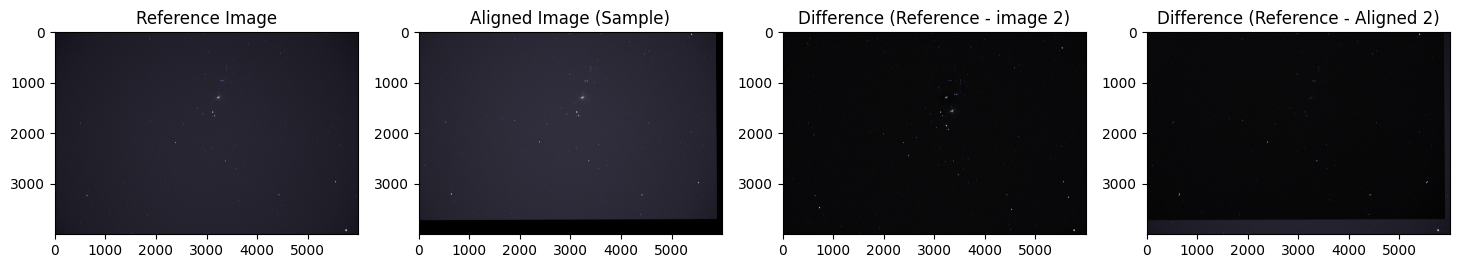

In [28]:
# Compute the difference between the reference and aligned image
difference_actual_img = np.abs(ref_img.astype(np.float32) - imageio.imread(os.path.join(input_dir, image_files[2])).astype(np.float32))
difference_aligned_img = np.abs(ref_img.astype(np.float32) - aligned_images[2].astype(np.float32))

# Normalize difference for visualization
difference_actual_display = difference_actual_img / np.max(difference_actual_img)  # Scale to [0,1]
difference_aligned_display = difference_aligned_img / np.max(difference_aligned_img)  # Scale to [0,1]

# Show images and their difference
fig, axes = plt.subplots(1, 4, figsize=(18, 6))

# Normalize original images for display
ref_display = ref_img / np.max(ref_img)
aligned_display = aligned_images[2] / np.max(aligned_images[2])

axes[0].imshow(ref_display)
axes[0].set_title("Reference Image")

axes[1].imshow(aligned_display)
axes[1].set_title("Aligned Image (Sample)")

axes[2].imshow(difference_actual_display, cmap="gray")
axes[2].set_title("Difference (Reference - image 2)")

axes[3].imshow(difference_aligned_display, cmap="gray")
axes[3].set_title("Difference (Reference - Aligned 2)")

plt.show()

In [29]:
print("Affine Matrix:\n", matrix)
print("Differnce Image:\n", difference_aligned_display)

Affine Matrix:
 [[ 1.00437463e+00 -1.32174265e-02  1.48597012e+02]
 [ 1.32174265e-02  1.00437463e+00 -2.26351697e+02]]
Differnce Image:
 [[[0.00392157 0.         0.01568628]
  [0.01568628 0.01960784 0.03529412]
  [0.03529412 0.03921569 0.05490196]
  ...
  [0.07843138 0.07450981 0.10588235]
  [0.08627451 0.08235294 0.11372549]
  [0.06666667 0.0627451  0.09411765]]

 [[0.01568628 0.01960784 0.03529412]
  [0.04313726 0.04705882 0.0627451 ]
  [0.04705882 0.05098039 0.06666667]
  ...
  [0.08235294 0.07843138 0.10980392]
  [0.08627451 0.08235294 0.11372549]
  [0.0627451  0.05882353 0.09019608]]

 [[0.03137255 0.02745098 0.04705882]
  [0.05490196 0.05098039 0.07058824]
  [0.0627451  0.05882353 0.07843138]
  ...
  [0.08235294 0.07843138 0.10980392]
  [0.08235294 0.07843138 0.10980392]
  [0.06666667 0.0627451  0.09411765]]

 ...

 [[0.09411765 0.06666667 0.12941177]
  [0.07843138 0.05098039 0.11372549]
  [0.07843138 0.05098039 0.11372549]
  ...
  [0.08235294 0.06666667 0.1254902 ]
  [0.06666667